# Exploratory data analysis
Code largely taken from the PyTorch [audio feature extraction tutorial](https://pytorch.org/audio/main/tutorials/audio_feature_extractions_tutorial.html#sphx-glr-tutorials-audio-feature-extractions-tutorial-py).

In [28]:
import os

import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [5]:
torch.random.manual_seed(0)

# Load Audio
CHORUS_WAVEFORM, SAMPLE_RATE = torchaudio.load("chorus/1.mp3")


def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(
        librosa.power_to_db(specgram), 
        origin="lower", 
        aspect="auto", 
        interpolation="nearest"
    )


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

In [6]:
# Define transform
spectrogram = T.MelSpectrogram(n_fft=512)

# Perform transform
spec = spectrogram(CHORUS_WAVEFORM)

# Define transform
spectrogram = T.Spectrogram(n_fft=512)

# Perform transform
spec = spectrogram(CHORUS_WAVEFORM)

/Users/Matt/Documents/GitHub/music-similarity/venv/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


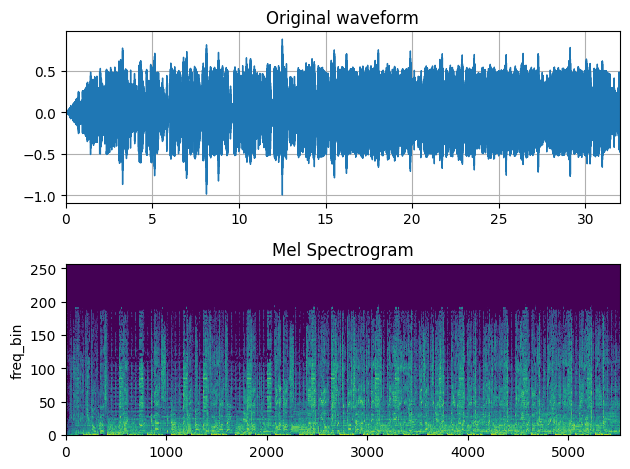

In [7]:
fig, axs = plt.subplots(2, 1)
plot_waveform(CHORUS_WAVEFORM, SAMPLE_RATE, title="Original waveform", ax=axs[0])
plot_spectrogram(spec[0], title="Mel Spectrogram", ax=axs[1])
fig.tight_layout()

In [44]:
# Desired song length in seconds
STANDARD_LENGTH = 25

def get_distance(ref_img, other_img):
    return torch.sqrt(torch.square(ref_img - other_img).mean()).item()

def get_mel_spectrogram(fname, n_fft):
    waveform, sample_rate = torchaudio.load(f"chorus/{fname}")

    # Ensure the audio is at least as long as the desired length
    if waveform.size(1) < STANDARD_LENGTH * sample_rate:
        # If the audio is shorter, pad it
        padding = STANDARD_LENGTH * sample_rate - waveform.size(1)
        waveform = torch.nn.functional.pad(waveform, (0, padding))
    elif waveform.size(1) > STANDARD_LENGTH * sample_rate:
        # If the audio is longer, extract the middle portion
        start = (waveform.size(1) - STANDARD_LENGTH * sample_rate) // 2
        waveform = waveform[:, start:start + STANDARD_LENGTH * sample_rate]

    n_fft = 512
    win_length = None
    hop_length = 512
    n_mels = 60

    mel_spectrogram = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm="slaney",
        n_mels=n_mels,
        mel_scale="htk",
    )
    spec = mel_spectrogram(waveform)

    return spec[0]


/Users/Matt/Documents/GitHub/music-similarity/venv/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (60) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


Root Mean Square Difference:  10.548910140991211


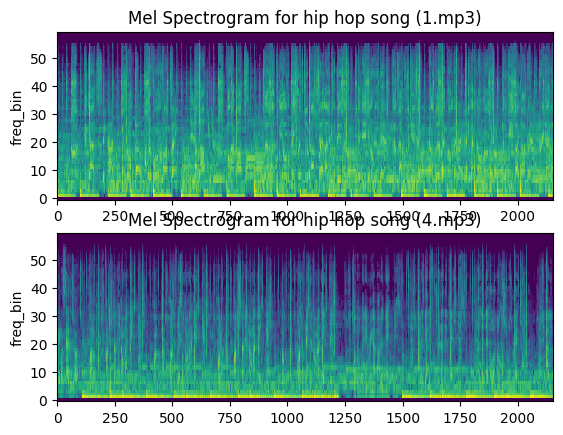

In [45]:
spec_1 = get_mel_spectrogram("1.mp3", 512)
spec_4 = get_mel_spectrogram("4.mp3", 512)

fig, axs = plt.subplots(2, 1)

plot_spectrogram(spec_1, title="Mel Spectrogram for hip hop song (1.mp3)", ax=axs[0])
plot_spectrogram(spec_4, title="Mel Spectrogram for hip hop song (4.mp3)", ax=axs[1])
print("Root Mean Square Difference: ", get_distance(spec_1, spec_4))

Root Mean Square Difference:  3.6788389682769775


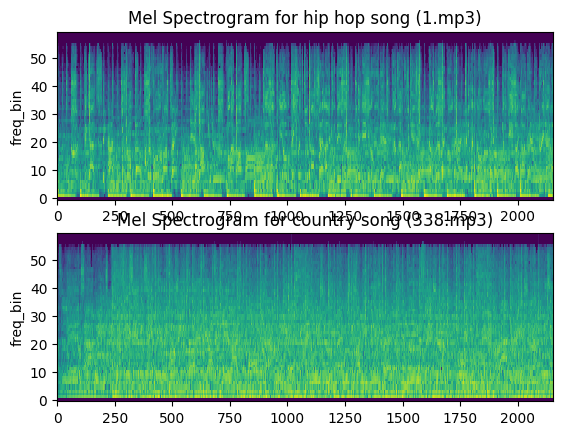

In [46]:
# Country song
spec_338 = get_mel_spectrogram("338.mp3", 512)

fig, axs = plt.subplots(2, 1)
plot_spectrogram(spec_1, title="Mel Spectrogram for hip hop song (1.mp3)", ax=axs[0])
plot_spectrogram(spec_338, title="Mel Spectrogram for country song (338.mp3)", ax=axs[1])
print("Root Mean Square Difference: ", get_distance(spec_1, spec_338))

In [47]:
def get_closest_and_furthest(ref_fname):
    ref_spec = get_mel_spectrogram(ref_fname, 512)

    fnames = os.listdir("chorus")

    min_dist = float("inf")
    min_fname = ""
    max_dist = float("-inf")
    max_fname = ""

    for fname in fnames:
        if fname == ref_fname:
            continue

        spec = get_mel_spectrogram(fname, 512)
        dist = get_distance(ref_spec, spec)

        if dist < min_dist:
            min_dist = dist
            min_fname = fname

        if dist > max_dist:
            max_dist = dist
            max_fname = fname

    return min_dist, min_fname, max_dist, max_fname

In [63]:
def play_audio(file_path):
    root = 'chorus/'

    file_path = os.path.join(root,file_path)
    audio_widget = Audio(filename=file_path, autoplay=True)
    display(audio_widget)

In [55]:
min_dist, min_fname, max_dist, max_fname = get_closest_and_furthest("846.mp3")

Closest song: 37.mp3 with distance: 10.081223487854004
Furthest song: 962.mp3 with distance: 15.017974853515625


In [ ]:
print(f"Closest song: {min_fname} with distance: {min_dist}")
play_audio(min_fname)

In [ ]:
print(f"Furthest song: {max_fname} with distance: {max_dist}")
play_audio(max_fname)

In [56]:
min_dist, min_fname, max_dist, max_fname = get_closest_and_furthest("15.mp3")

Closest song: 236.mp3 with distance: 4.221373081207275
Furthest song: 962.mp3 with distance: 16.02067756652832


In [ ]:
print(f"Closest song: {min_fname} with distance: {min_dist}")
play_audio(min_fname)

In [ ]:
print(f"Furthest song: {max_fname} with distance: {max_dist}")
play_audio(max_fname)

In [57]:
def create_relationships_dataset():
    
    relationships = {
        "ref": [],
        "other": [],
        "is_positive": []
    }

    fnames = os.listdir("chorus")
    
    # seen = {}
    # for fname in fnames:
    #     seen[fname] = False
    
    for ref_fname in fnames:
        ref_spec = get_mel_spectrogram(ref_fname, 512)

        # fnames_to_check = [fname for fname in seen if seen[fname] is False]

        min_dist = float("inf")
        min_dist_fname = ""
        max_dist = float("-inf")
        max_dist_fname = ""

        for other_fname in fnames:
            if other_fname == ref_fname:
                continue

            spec = get_mel_spectrogram(other_fname, 512)
            dist = get_distance(ref_spec, spec)

            if dist < min_dist:
                min_dist = dist
                min_dist_fname = other_fname

            if dist > max_dist:
                max_dist = dist
                max_dist_fname = other_fname

        if max_dist_fname:
            relationships["ref"].append(ref_fname)
            relationships["other"].append(max_dist_fname)
            relationships["is_positive"].append(0)

            relationships["ref"].append(ref_fname)
            relationships["other"].append(min_dist_fname)
            relationships["is_positive"].append(1)
            # seen[ref_fname] = True
            # seen[max_dist_fname] = True

    return relationships

In [58]:
fnames = os.listdir("chorus")

spectra = []
for fname in fnames:
    spec = get_mel_spectrogram(fname, 512)
    spectra.append(spec.flatten())

spectra = torch.stack(spectra, dim=0)

In [59]:
spectra.shape

torch.Size([794, 129240])

In [60]:
scaler = StandardScaler()
pca = PCA()
spectra_normed = scaler.fit_transform(spectra)
spectra_pca = pca.fit_transform(spectra_normed)

In [61]:
spectra_pca_df = pd.DataFrame(spectra_pca, columns=fnames)

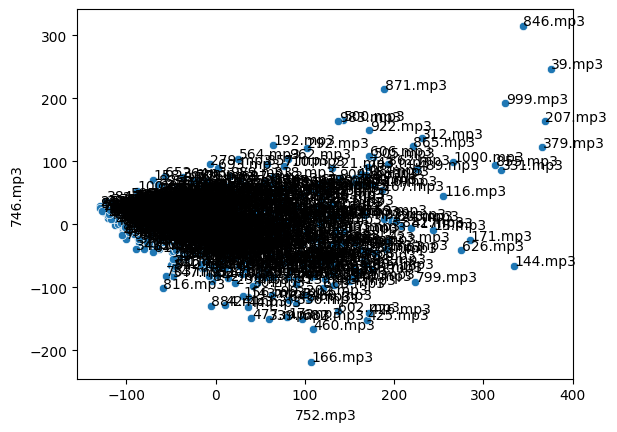

In [65]:
sns.scatterplot(x=spectra_pca_df.iloc[:, 0], y=spectra_pca_df.iloc[:, 1])

for i, fname in enumerate (spectra_pca_df):
    plt.annotate(fname, (spectra_pca_df.iloc[i, 0]+0.7, spectra_pca_df.iloc[i, 1]+0.5) )

TODO: Try MFCC coefficients for PCA + clustering?